In [50]:
# importing required pakages and libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from optbinning import OptimalBinning
from sklearn.preprocessing import  MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.svm import  SVC
from sklearn.linear_model import LogisticRegression
from scipy.stats import zscore
import xgboost
from sklearn.ensemble import  RandomForestClassifier
from sklearn.ensemble.gradient_boosting import  GradientBoostingClassifier
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.ensemble import  AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold
import warnings
warnings.filterwarnings('ignore')
sb.set()

In [51]:
ds = pd.read_csv('adult.csv')
ds

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


### EDA and Data-preprocessing

In [52]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


From above dataset we see no sign of missing values.

In [53]:
ds.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


From above table, we can infer that capital.gain and capital.gain may have very skewed distribution.

In [54]:
# here we are separating columns with int and object dtypes for separate analysis.
numeric_col = []
cat_col = []
for col in ds.columns:
    if str(ds[col].dtype) == 'int64':
        numeric_col.append(col)
    else:
        cat_col.append(col)
        
print('numeric columns: \n',numeric_col,'\n')
print('categorical columns: \n',cat_col)

numeric columns: 
 ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week'] 

categorical columns: 
 ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country', 'income']


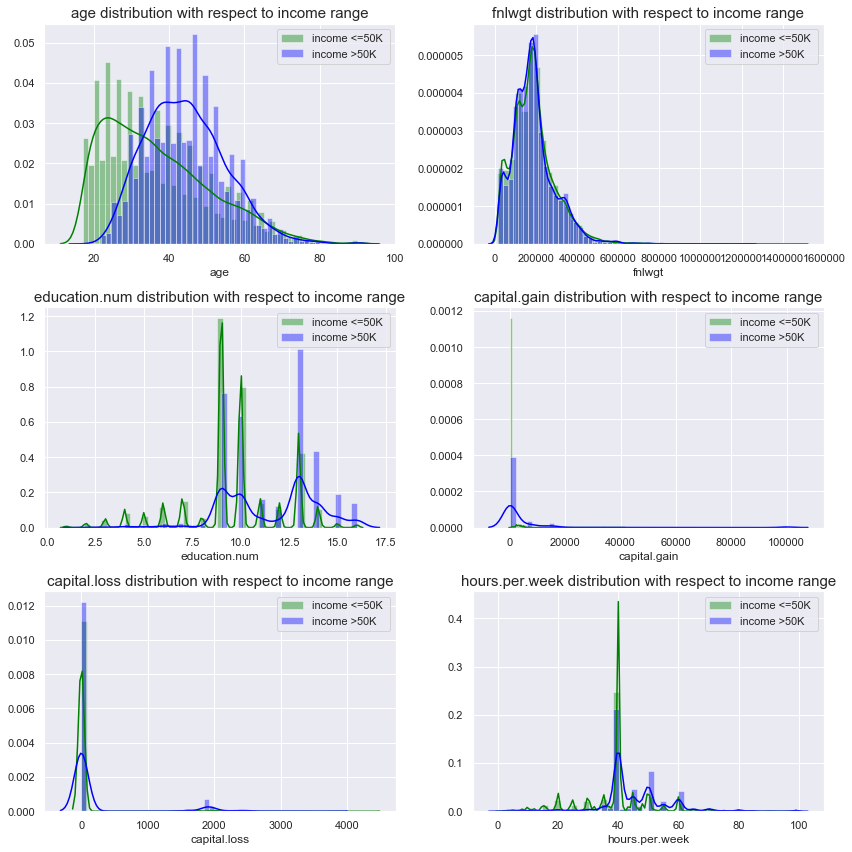

In [55]:
for i, col in enumerate(numeric_col):
    
    plt.subplot(3,2, i+1)

    sb.distplot(ds[col][ds['income'] == '<=50K'], kde = True, bins = 50 , color = 'green')
    sb.distplot(ds[col][ds['income'] == '>50K'], kde = True, bins = 50, color = 'blue')


    plt.legend(['income <=50K ','income >50K'])

    plt.title(col+' distribution with respect to income range', fontsize = 15)
    fig, ax = plt.gcf(), plt.gca()
    fig.set_size_inches(12,12)
    plt.tight_layout()
plt.show()

From above plots, we can see that there is more chances of lower age group of 20-30 years to earn less than 50K, whereas, there is more chances of higher age group of 30-50 years to earn more than 50K.

And also, higher educational num (educational qualification) may help in eventually earning higher then 50K.

(array([1, 2, 3, 4, 5, 6]), <a list of 6 Text xticklabel objects>)

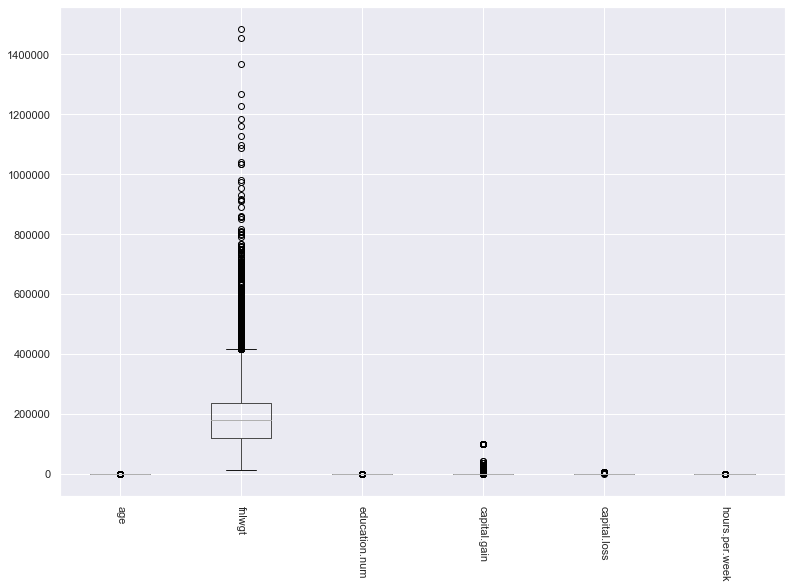

In [56]:
ds.boxplot(column = list(ds[numeric_col].columns) ,
                                               figsize = (13,9))
plt.xticks(rotation = -90)

Here, we see numeric columns are in different scale and has outliers, but we will not try to scale or transform the data, rather we will try to bin the numeric columns into groups in this project. By doing so, we don't have to worry about data being skewed or presence of outliers.

In [57]:
# Defining function to visualize descrete categorical variables.
def bar_chart(feature):
    
    less = ds[ds['income'] == '<=50K'][feature].value_counts()
    more = ds[ds['income'] == '>50K'][feature].value_counts()
    df = pd.DataFrame([less,more])
    df.index = ['income <=50K ','income >50K']
    df.plot(kind = 'bar', stacked = False, figsize = (8,6))
    plt.xticks(rotation = 0)

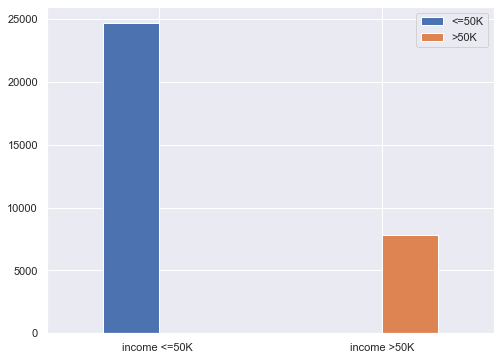

In [58]:
bar_chart('income')

From above plot we can say that our target class is unbalanced as no. of income <=50K is much greater then that of income >50K.

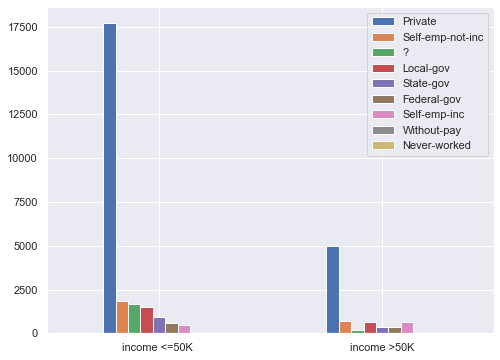

In [59]:
bar_chart('workclass')

Here, we can see majority of employees are from 'Private' workclass, and also there are some unknown/missing values represented by '?' to which we shall  impute.

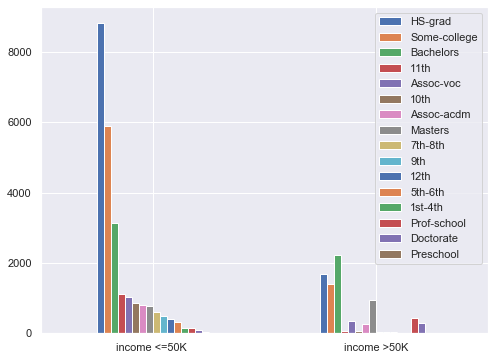

In [60]:
bar_chart('education')

Here, we can see that majority of educational qualification are from Bachelors degrees whose income are greater then 50K.

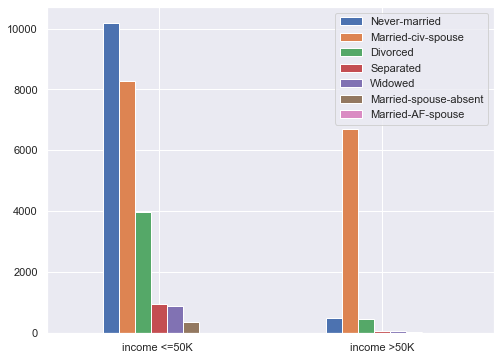

In [61]:
bar_chart('marital.status')

Here we see majority of Married civilian spouse earns more then 50K.

Also people who are never married is likely to earn less then 50K.

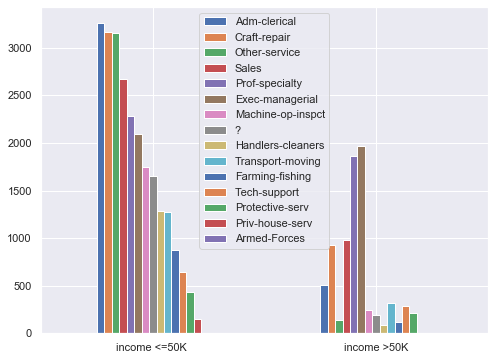

In [62]:
bar_chart('occupation')

Here, we see occupation having 'Adm-clerical' is having highest count for income <=50 K, whereas, Exec-managerial post is having highest count for income >50K. Also, we shall impute missing data represented by '?'.

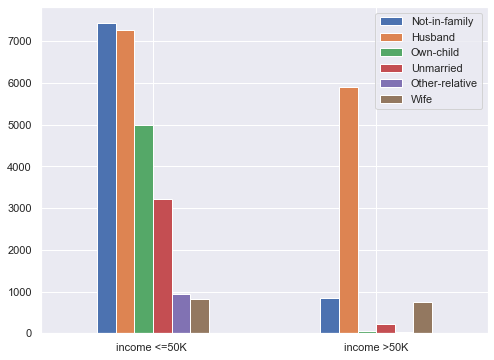

In [63]:
bar_chart('relationship')

Here we can see that, all relationship status but except 'Not-in-family' and 'Wife' have significantly lower number that are having income more then 50K. 


Also, status like 'Husband' and 'Wife' can we grouped together to form a married status for removing redundant data.

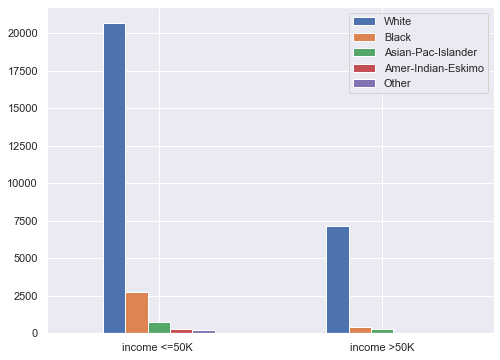

In [64]:
bar_chart('race')

Here we see that majority of race are from White.

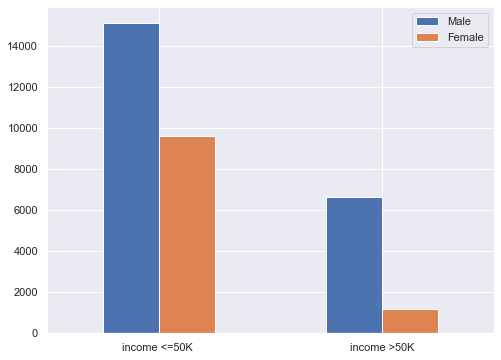

In [65]:
bar_chart('sex')

From above plot, we can infer that Female employees are less likely to earn income more then 50K compared to Male employees.

In [66]:
# removing redundant category in feature relationship into one category.
ds['relationship'][ds['relationship'] == 'Husband'] = 'Married'
ds['relationship'][ds['relationship'] == 'Wife'] = 'Married'

In [67]:
ds['native.country'].value_counts()

United-States                 29170
Mexico                          643
?                               583
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Guatemala                        64
Japan                            62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                             31
Greece                      

Here we see that last country i.e. 'Holand-Netherlands' has only one value in entire dataset, so its not useful for modelling, so we drop it. Also, we shall not impute '?' country, as it has large count and rather treat it as seperate category.

In [68]:
ds.drop(ds[ds['native.country'] =='Holand-Netherlands'].index, inplace = True) 

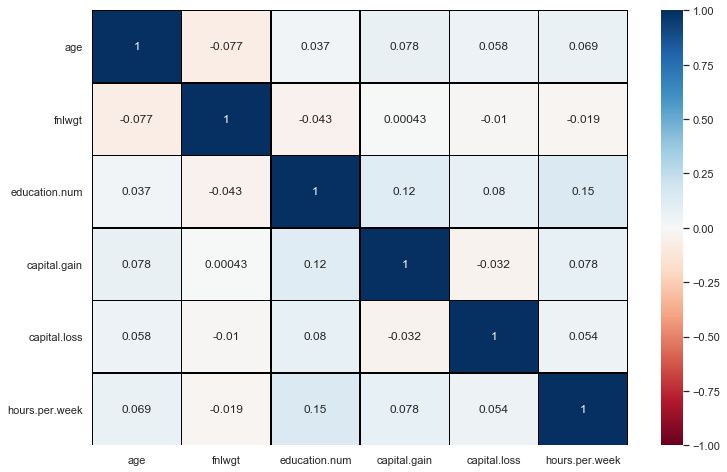

In [69]:
plt.figure(figsize = (12,8))
sb.heatmap(ds[numeric_col].corr(), cmap = 'RdBu', vmin = -1, vmax = 1, center = 0, 
           linewidth = .5, linecolor = 'black', annot = True)

From above heatmap, we don't see any significant correlations among variables.

In [70]:
# imputing missing value of workclass
ds['workclass'].replace('?', np.nan, inplace = True)
ds['workclass'] = ds.groupby(['education','sex',
                               'relationship'])['workclass'].transform(lambda x:
                               x.fillna(x.mode()[0]))

In [71]:
# imputing missing value of occupation
ds['occupation'].replace('?', np.nan, inplace = True)
ds['occupation'] = ds.groupby(['education','sex',
                               'relationship'])['occupation'].transform(lambda x:
                               x.fillna(x.mode()[0]))

In [72]:
ds['income'] = ds['income'].map({'<=50K':0, '>50K':1 })

In [73]:
# dropping education num as a redundant feature.
ds.drop( columns = 'education.num', axis = 1, inplace = True)

In [74]:
 x_train, x_test, y_train, y_test = train_test_split(ds.drop('income',1), 
                                                     ds.income ,
                                                     stratify = ds.income,
                                                     random_state = 42,
                                                     test_size = 0.3)

In [75]:
cat_col.remove('income')

In [76]:
cat_col

['workclass',
 'education',
 'marital.status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native.country']

In [77]:
cat_col.append('capital.loss')
cat_col.append('capital.gain')

In [78]:
cat_col

['workclass',
 'education',
 'marital.status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native.country',
 'capital.loss',
 'capital.gain']

In [79]:
# supervised binning categorical columns present in cat_col list,  using 'OptimalBinning' class.
for col in  cat_col:
    
    optb = OptimalBinning(name =  col, dtype= 'categorical',
                      solver='mip',
                      class_weight = 'balanced',
                      cat_cutoff = 0.1)
    
    optb.fit(x_train[col].values, y_train)
    print('binning status for column ' + col+ ' is',optb.status,'\n')
    
    x_train[col] = optb.transform(x_train[col].values , metric='woe')
    x_test[col] = optb.transform(x_test[col].values , metric='woe')

binning status for column workclass is OPTIMAL 

binning status for column education is OPTIMAL 

binning status for column marital.status is OPTIMAL 

binning status for column occupation is OPTIMAL 

binning status for column relationship is OPTIMAL 

binning status for column race is OPTIMAL 

binning status for column sex is OPTIMAL 

binning status for column native.country is OPTIMAL 

binning status for column capital.loss is OPTIMAL 

binning status for column capital.gain is OPTIMAL 



In [80]:
# supervised binning numerical columns present in  numeric_col_new list, using 'OptimalBinning' class.
numeric_col_new = ['age','fnlwgt','hours.per.week']

for col in  numeric_col_new:
    
    optb = OptimalBinning(name =  col, dtype="numerical",
                      solver="cp",
                      outlier_detector  =  'range',
                      class_weight = 'balanced')
    optb.fit(x_train[col].values, y_train)
    print('binning status for column ' + col+ ' is',optb.status,'\n')
    
    x_train[col] = optb.transform(x_train[col].values , metric='woe')
    x_test[col] = optb.transform(x_test[col].values , metric='woe')

binning status for column age is OPTIMAL 

binning status for column fnlwgt is OPTIMAL 

binning status for column hours.per.week is OPTIMAL 



Here, we are transforming the numeric data based on Weight of Evidence (WOE). By doing so, we don't have to bother about skewed data neither the presence of outliers.

In [81]:
k =  KFold(n_splits = 10)

### Base Model Evaluation

model: RandomForestClassifier()
CV score:0.7393191037308657
score_std: 0.012649757938790338
----------
model: LogisticRegression()
CV score:0.7556083748610671
score_std: 0.008805514300495828
----------
model: SVC()
CV score:0.7502331198031125
score_std: 0.010712123885699844
----------
model: AdaBoostClassifier()
CV score:0.7622553768217198
score_std: 0.010913348545712877
----------
model: GradientBoostingClassifier()
CV score:0.7666994321755153
score_std: 0.011303261487445234
----------
model: KNeighborsClassifier()
CV score:0.7465996421207455
score_std: 0.011315554717772893
----------
model: XGBClassifier(silent=True)
CV score:0.7651554324036496
score_std: 0.010561087969476536
----------
model: DecisionTreeClassifier()
CV score:0.7028267870563629
score_std: 0.010550887453207576
----------
model: GaussianNB()
CV score:0.7236138090912232
score_std: 0.010634566679628537
----------


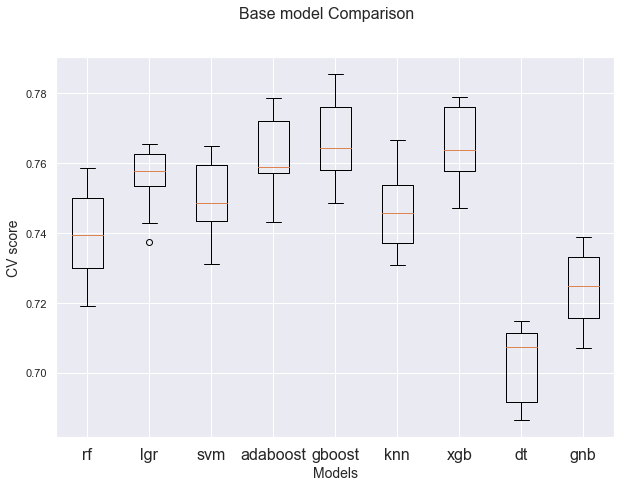

In [82]:
rf = RandomForestClassifier()
svm = SVC()
lgr = LogisticRegression()
adaboost =  AdaBoostClassifier()
gboost = GradientBoostingClassifier()
knn = KNeighborsClassifier()
xgb = xgboost.XGBClassifier(silent = True)
dt = DecisionTreeClassifier()
gnb = GaussianNB()

models = [rf, lgr, svm, adaboost, gboost, knn, xgb, dt, gnb]

scores = []
for model in models:
    
    score = cross_val_score(model, x_train, y_train, cv = k, scoring = 'f1_macro', n_jobs = -1 )
    mean_score = score.mean()
    std_score = score.std()
    
    print('model: {}'.format(model))
    print('CV score:{}'.format(mean_score))
    print('score_std:',std_score)
    print('----------')
    scores.append(score)
    
fig = plt.figure()
fig.suptitle('Base model Comparison', fontsize = 16)
ax = fig.add_subplot(111)
plt.boxplot(scores)
ax.set_xticklabels(['rf', 'lgr','svm', 'adaboost', 'gboost', 'knn', 'xgb','dt','gnb'],
                  fontsize = 16)
plt.xlabel('Models', fontsize = 14)
plt.ylabel('CV score', fontsize = 14)
fig.set_size_inches(10,7)
plt.show() 

Based on above cross-val-score, we select adaboost, gboost, lgr and xgb models for further tuning.

### Hyper-parameter tuning

In [83]:
# initializing parameters
param_gboost =  dict(
   learning_rate = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
   max_depth = [ 3, 4, 5, 6, 8, 10, 12, 15],
   n_estimators = [100, 150, 200],
   min_samples_split = [1,2,3],
   min_samples_leaf = [1,2], random_state = [41,42,43])

param_xgb = dict( learning_rate = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
     max_depth = [ 3, 4, 5, 6, 8, 10, 12, 15],
     min_child_weight = [ 1, 3, 5, 7 ],
     gamma = [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     colsample_bytree = [ 0.3, 0.4, 0.5 , 0.7 ], alpha = [0.05,0.1,0.5,0.75,1,1.75,2],
                 reg_lambda = [0.05,0.1,0.5,0.75,1,1.75,2])

param_lgr = dict(penalty = ['l1','l2'],  C = np.logspace(4,-4,60), 
                 solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                 max_iter = [100,150,200,250,300])

param_adaboost = dict(n_estimators = [50, 100, 150, 200],
                    learning_rate = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
                     algorithm = ['SAMME', 'SAMME.R'],
                      random_state = [41,42,43])

In [84]:
model_param_list = [( gboost,param_gboost), ( xgb,param_xgb), (lgr,param_lgr),
                   (adaboost, param_adaboost)]

In [85]:
%%time
best_estimator_list = []
for model, param in model_param_list:
    
    r_search = RandomizedSearchCV(model, param, cv = k, n_jobs = -1, scoring = 'f1',
                                  random_state = 42)
    r_search.fit( x_train, y_train.values.ravel())
    best_cvscore = r_search.best_score_
    best_param = r_search.best_params_
    best_estimator = r_search.best_estimator_
    best_estimator_list.append(best_estimator)
    
    print('model:',model)
    print('best_cvscore:',best_cvscore)
    print('best_param:', best_param)
    print('\n')
    
print('best_estimators:',best_estimator_list)

model: GradientBoostingClassifier()
best_cvscore: 0.6391116272267976
best_param: {'random_state': 41, 'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 3, 'learning_rate': 0.3}


model: XGBClassifier(silent=True)
best_cvscore: 0.6372704579238886
best_param: {'reg_lambda': 2, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.3, 'gamma': 0.0, 'colsample_bytree': 0.3, 'alpha': 0.5}


model: LogisticRegression()
best_cvscore: 0.6161646121167673
best_param: {'solver': 'saga', 'penalty': 'l1', 'max_iter': 300, 'C': 4.075392965871778}


model: AdaBoostClassifier()
best_cvscore: 0.623340650824525
best_param: {'random_state': 41, 'n_estimators': 200, 'learning_rate': 0.2, 'algorithm': 'SAMME.R'}


best_estimators: [GradientBoostingClassifier(learning_rate=0.3, random_state=41), XGBClassifier(alpha=0.5, colsample_bytree=0.3, gamma=0.0, learning_rate=0.3,
              reg_lambda=2, silent=True), LogisticRegression(C=4.075392965871778, max_iter=300, penalty=

### Testing

In [95]:
print('*******TRAIN RESULTS*******')
print('\n')

for model in best_estimator_list:
    model.fit(x_train, y_train.values.ravel())
    y_pred = model.predict(x_train)
    score = accuracy_score(y_train, y_pred)
    print('model',model,'\n')
    print('accuracy:',round(score*100,2),'%','\n')
    print('f1_score:',round(f1_score(y_train,y_pred)*100,2),'%','\n')
    print('auc_roc_score:', round(roc_auc_score(y_train,y_pred)*100,2),'%','\n')
    print('Classification report:','\n', classification_report(y_train, y_pred))
    print('------------------------------------------------------------------------------')
    print('\n')

*******TRAIN RESULTS*******


model GradientBoostingClassifier(learning_rate=0.3, random_state=41) 

accuracy: 84.84 % 

f1_score: 65.65 % 

auc_roc_score: 76.42 % 

Classification report: 
               precision    recall  f1-score   support

           0       0.88      0.93      0.90     17303
           1       0.72      0.60      0.66      5489

    accuracy                           0.85     22792
   macro avg       0.80      0.76      0.78     22792
weighted avg       0.84      0.85      0.84     22792

------------------------------------------------------------------------------


model XGBClassifier(alpha=0.5, colsample_bytree=0.3, gamma=0.0, learning_rate=0.3,
              reg_lambda=2, silent=True) 

accuracy: 84.49 % 

f1_score: 64.3 % 

auc_roc_score: 75.45 % 

Classification report: 
               precision    recall  f1-score   support

           0       0.87      0.93      0.90     17303
           1       0.72      0.58      0.64      5489

    accuracy          

In [96]:
print('*******TEST RESULTS********')
print('\n')

for model in best_estimator_list:
    model.fit(x_train, y_train.values.ravel())
    y_pred = model.predict(x_test)
    score = accuracy_score(y_test, y_pred)
    
    print('Model:',model,'\n')
    print('accuracy:',round(score*100,2),'%','\n')
    print('f1_score:',round(f1_score(y_test,y_pred)*100,2),'%','\n')
    print('auc_roc_score:', round(roc_auc_score(y_test,y_pred)*100,2),'%','\n')
    print('confusion_matrix:','\n',confusion_matrix(y_test,y_pred),'\n')
    print('Classification report:','\n', classification_report(y_test, y_pred))
    print('------------------------------------------------------------------------------')
    print('\n')

*******TEST RESULTS********


Model: GradientBoostingClassifier(learning_rate=0.3, random_state=41) 

accuracy: 84.12 % 

f1_score: 63.77 % 

auc_roc_score: 75.22 % 

confusion_matrix: 
 [[6852  564]
 [ 987 1365]] 

Classification report: 
               precision    recall  f1-score   support

           0       0.87      0.92      0.90      7416
           1       0.71      0.58      0.64      2352

    accuracy                           0.84      9768
   macro avg       0.79      0.75      0.77      9768
weighted avg       0.83      0.84      0.84      9768

------------------------------------------------------------------------------


Model: XGBClassifier(alpha=0.5, colsample_bytree=0.3, gamma=0.0, learning_rate=0.3,
              reg_lambda=2, silent=True) 

accuracy: 84.24 % 

f1_score: 63.63 % 

auc_roc_score: 75.02 % 

confusion_matrix: 
 [[6883  533]
 [1006 1346]] 

Classification report: 
               precision    recall  f1-score   support

           0       0.87      0

From above train and test results, we see that XGBoost and GradientBoost performed almost the same, but since GradientBoost performed slightly better based on f1 score and roc auc score, therefore, we can select our model as GradientBoost for this project.

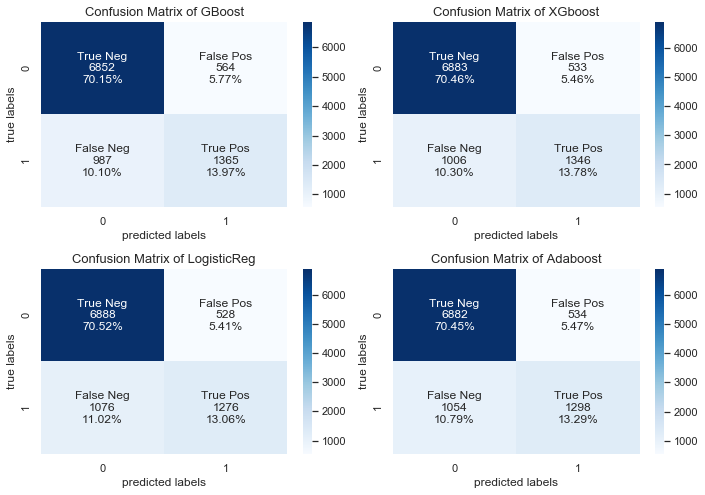

In [88]:
# visualizing confusion matrix  with the help of heatmaps.
model_index = [0,1,2,3]
model = ['GBoost','XGboost','LogisticReg','Adaboost']

for index ,model, model_name in zip(model_index,best_estimator_list,model):
    plt.subplot(3,2, index + 1 )
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    c_matric = confusion_matrix(y_test, y_pred)
    groups = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                c_matric.flatten()]
    group_percent = ['{0:.2%}'.format(value) for value in
                     c_matric.flatten()/np.sum(c_matric)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(groups,group_counts,group_percent)]
    labels = np.asarray(labels).reshape(2,2)
    sb.heatmap(c_matric, annot=labels, fmt='', cmap='Blues')
    plt.title('Confusion Matrix of ' + model_name, fontsize = 13)
    plt.ylabel('true labels')
    plt.xlabel('predicted labels')
    fig, ax = plt.gcf(), plt.gca()
    fig.set_size_inches(10, 10)
    plt.tight_layout()
plt.show()

From above heatmaps, we can see that GradientBoost model performed better then other models in predicting minor class (i.e. income >50K), which therefore reflected on its f1 score and roc auc score.

In [91]:
# selecting the best performing model.
selected_model = GradientBoostingClassifier(learning_rate=0.3, random_state=41) 
selected_model.fit(x_train, y_train)
y_pred = selected_model.predict(x_test)

In [92]:
test_df = pd.DataFrame({'Actual income':y_test.values,'Predicted income':y_pred})

In [93]:
test_df.to_csv('census_income_pred.csv', index = False)
print('Predicted result stored sucessfully.')

Predicted result stored sucessfully.


In [94]:
# Saving the final model as GradientBoostingClassifier.
import joblib

joblib.dump(selected_model, 'loan_status_pred.obj')
print('Model successfully saved.')

Model successfully saved.
